#STAT 6289 Final Project
##Group member: Turner Luo, Xuanyu Chen


###Load the data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import random
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")\

Found 2000 files belonging to 1 classes.


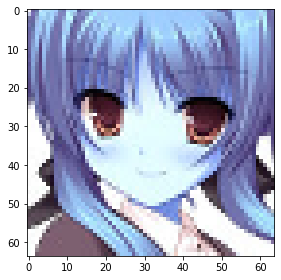

In [22]:
file_path = "/content/drive/MyDrive/GWU/STAT6289/anime face 2000"
batch_s = 64
Anime_face = tf.keras.preprocessing.image_dataset_from_directory(
    file_path, label_mode = None, image_size = (64,64), batch_size = batch_s)
plt.figure(figsize=(4,4))
image = cv2.imread("/content/drive/MyDrive/GWU/STAT6289/anime face 2000/1233.png")
plt.imshow(image)
plt.tight_layout()

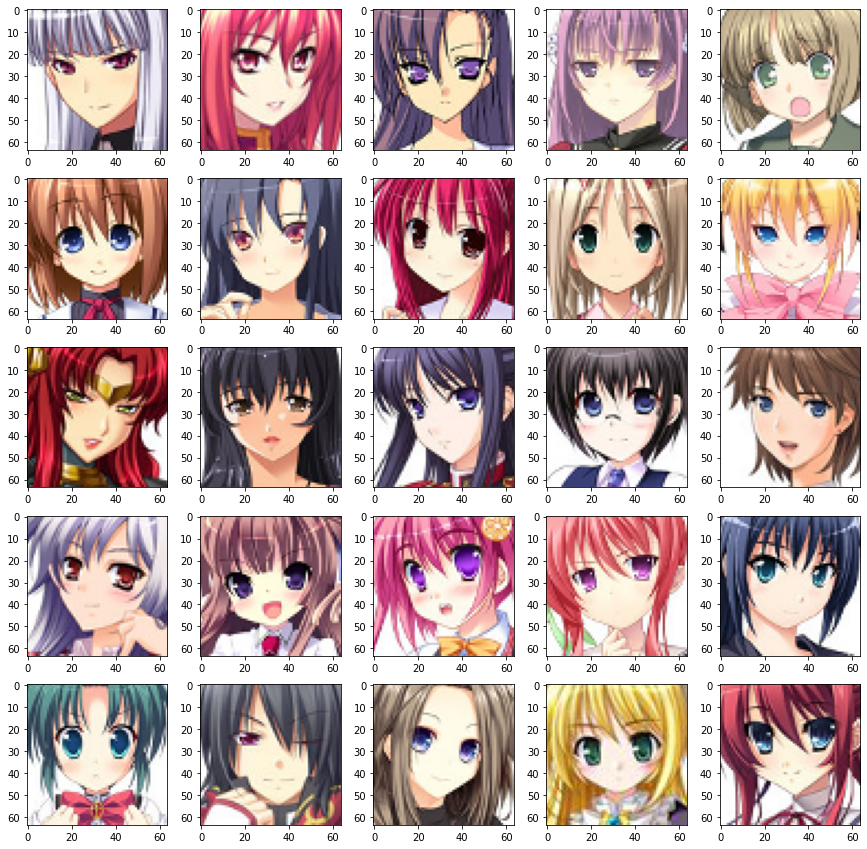

In [23]:
def Show_Image(Anime_face):
    plt.figure(figsize=(15,15))
    for images in Anime_face.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("on")           
Show_Image(Anime_face)

In [7]:
Anime_face = Anime_face.map(lambda x: x / 255.0)
Anime_face

<MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

###Building the Generator

In [8]:
latent_dim = 100
g_resolution=2

modelG = Sequential()
modelG.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
modelG.add(Reshape((4,4,256)))
modelG.add(UpSampling2D())
modelG.add(Conv2D(256,kernel_size=3,padding="same"))
modelG.add(BatchNormalization(momentum=0.8))
modelG.add(Activation("relu"))
modelG.add(UpSampling2D())
modelG.add(Conv2D(256,kernel_size=3,padding="same"))
modelG.add(BatchNormalization(momentum=0.8))
modelG.add(Activation("relu"))
modelG.add(UpSampling2D())
modelG.add(Conv2D(256,kernel_size=3,padding="same"))#
modelG.add(BatchNormalization(momentum=0.8))
modelG.add(Activation("relu"))
modelG.add(UpSampling2D())
modelG.add(Conv2D(128,kernel_size=3,padding="same"))
modelG.add(BatchNormalization(momentum=0.8))
modelG.add(Activation("relu"))
modelG.add(Conv2D(3,kernel_size=3,padding="same"))
modelG.add(Activation("tanh"))

modelG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 256)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 256)         0

###Create a random image from untrained generator

(-0.5, 63.5, 63.5, -0.5)

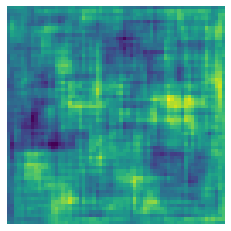

In [9]:
seed = tf.random.normal([1, latent_dim])
Generated_Image = modelG(seed, training=False)

plt.imshow(Generated_Image[0, :, :, 0])
plt.axis("off")

###Build the Discriminator

In [10]:
modelD = Sequential()
modelD.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
modelD.add(ZeroPadding2D(padding=((0,1),(0,1))))
modelD.add(BatchNormalization(momentum=0.8))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
modelD.add(BatchNormalization(momentum=0.8))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
modelD.add(BatchNormalization(momentum=0.8))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
modelD.add(BatchNormalization(momentum=0.8))
modelD.add(LeakyReLU(alpha=0.2))
modelD.add(Dropout(0.25))
modelD.add(Flatten())
modelD.add(Dense(1, activation="sigmoid"))

modelD.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 17, 17, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 17, 17, 64)       256       
 hNormalization)                                      

###Put untrained image into untrained discriminator

In [11]:
Discriminator_Verdict = modelD(Generated_Image)
print (Discriminator_Verdict)

tf.Tensor([[0.50017923]], shape=(1, 1), dtype=float32)


###Building the GAN

In [13]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = modelD
        self.generator = modelG
        self.latent_dim = latent_dim

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn
        self.discriminator_loss_metric = tf.keras.metrics.Mean(name="discriminator_loss")
        self.generator_loss_metric = tf.keras.metrics.Mean(name="generator_loss")

    @property
    def metrics(self):
        return [self.discriminator_loss_metric, self.generator_loss_metric]
    def train_step(self, real_images):
        
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
      
        generated_images = self.generator(seed)
      
        combined_images = tf.concat([generated_images, real_images], axis=0)
      
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
     
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
    
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            discriminator_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

       
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

   
        misleading_labels = tf.zeros((batch_size, 1))

       
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            generator_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(generator_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        
        self.discriminator_loss_metric.update_state(discriminator_loss)
        self.generator_loss_metric.update_state(generator_loss)
        return {"discriminator_loss": self.discriminator_loss_metric.result(), "generator_loss": self.generator_loss_metric.result()}

###Train the GAN

In [16]:
epochs = 100
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)

loss_fn = tf.keras.losses.BinaryCrossentropy()
model = GAN(discriminator=modelD, generator=modelG, latent_dim=latent_dim)
model.compile(discriminator_optimizer=discriminator_opt, generator_optimizer=generator_opt, loss_fn=loss_fn)
history = model.fit(Anime_face, epochs=epochs)

Epoch 1/100
32/32 [==============================] - 6s 111ms/step - discriminator_loss: 0.5854 - generator_loss: 0.9621
Epoch 2/100
32/32 [==============================] - 4s 111ms/step - discriminator_loss: 0.6144 - generator_loss: 0.8621
Epoch 3/100
32/32 [==============================] - 4s 110ms/step - discriminator_loss: 0.5745 - generator_loss: 0.9981
Epoch 4/100
32/32 [==============================] - 4s 110ms/step - discriminator_loss: 0.5643 - generator_loss: 1.0980
Epoch 5/100
32/32 [==============================] - 4s 110ms/step - discriminator_loss: 0.5890 - generator_loss: 1.0128
Epoch 6/100
32/32 [==============================] - 4s 110ms/step - discriminator_loss: 0.5555 - generator_loss: 1.0379
Epoch 7/100
32/32 [==============================] - 4s 110ms/step - discriminator_loss: 0.5358 - generator_loss: 1.1199
Epoch 8/100
32/32 [==============================] - 4s 110ms/step - discriminator_loss: 0.5020 - generator_loss: 1.2400
Epoch 9/100
32/32 [=============

###Visualise the result

Text(0.5, 1.0, 'Learning Curve')

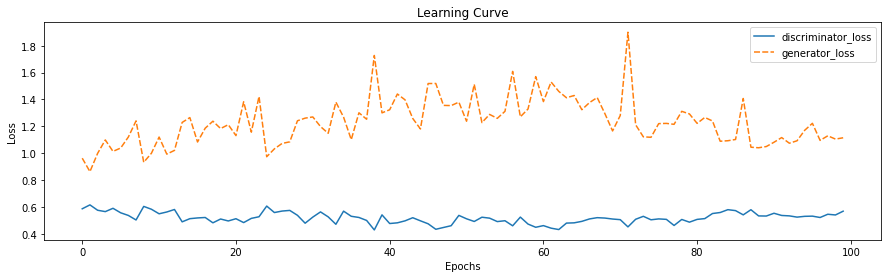

In [17]:
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4))
ax=sns.lineplot(data=history_df)
ax.set(xlabel ="Epochs")
ax.set(ylabel ="Loss")
ax.set_title("Learning Curve")

In [18]:
num_img=25

def Ai_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = modelG(seed)
    generated_image *= 255 
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("/content/drive/MyDrive/Ai Anime Face/Image{:02d}.png".format(i)) 
    return 
Images = Ai_Generator()

Found 25 files belonging to 1 classes.


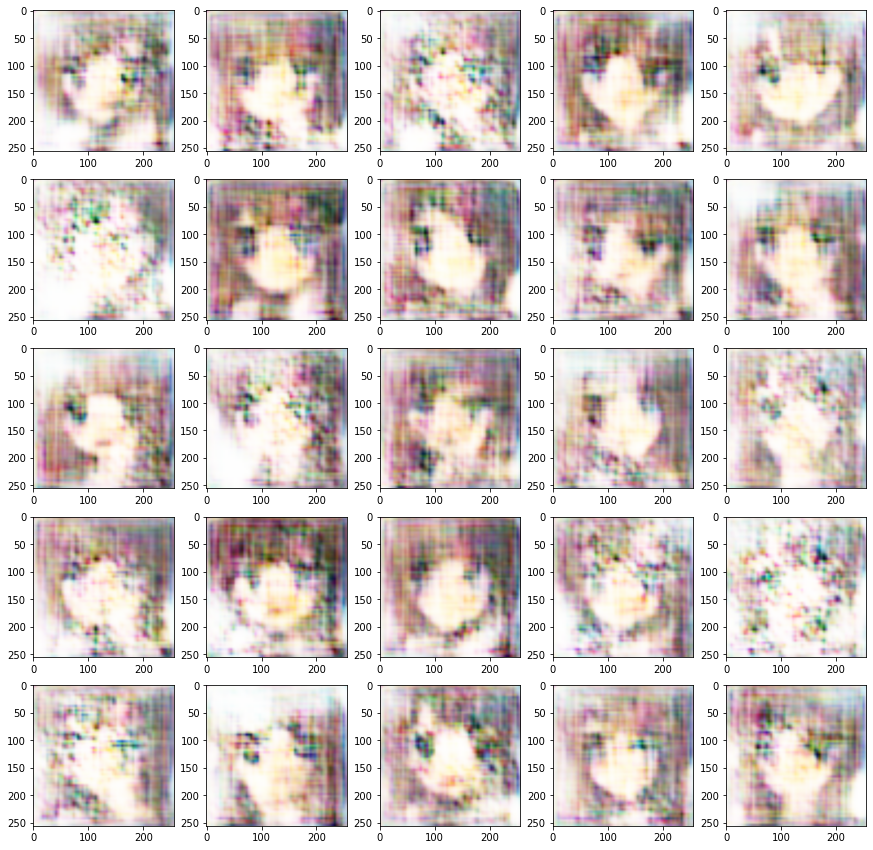

In [24]:
Generated_path = "/content/drive/MyDrive/Ai Anime Face"
Image_generated = tf.keras.preprocessing.image_dataset_from_directory(Generated_path, label_mode = None)
Show_Image(Image_generated)